# Deploy Llama2-7b on Amazon SageMaker using LMI containers

In this notebook, we deploy the [Llama2-7B](https://huggingface.co/TheBloke/Llama-2-7b-Chat-fp16) model on SageMaker by leveraging the 
[SageMaker Large Model Inference Container](https://github.com/aws/deep-learning-containers/blob/master/available_images.md#large-model-inference-containers). For the purpose of this notebook, we'll use the weights from the following source: - https://huggingface.co/TheBloke/Llama-2-7B-Chat-fp16

For information on Llama2, please refer the paper [Llama 2: Open Foundation and Fine-Tuned Chat Models](https://arxiv.org/pdf/2307.09288.pdf).

This notebook explains how to deploy model optimized for latency and throughput. The tuning guide is available [LLM Tuning Guide](https://github.com/aws/deep-learning-containers/blob/master/available_images.md#large-model-inference-containers). There are some key Gen Ai Patterns and use cases and they need different settings when hosting the model. The typical broad use case caterization would be 
Chatbot / QA applications which need the ability to handle large model inputs and large model outputs. With contextual applications these need prescritive and factual responses back from LLM which can be controlled by setting the appropriate decoding parameters. Latency and accuracy is top priority.

Also, we will show to deploy AWQ-quntized model on Amazon SageMaker Endpoint.

## License agreement
 - View license information https://huggingface.co/meta-llama before using the model.
 - This notebook is a sample notebook and not intended for production use. Please refer to the licence at https://github.com/aws/mit-0. 

## Resources
- [Deep Learning Containers](https://docs.aws.amazon.com/sagemaker/latest/dg/large-model-inference-dlc.html)
- [Deep Java Library - Large Model Inference](https://docs.djl.ai/docs/serving/serving/docs/large_model_inference.html)

## Step 1: Setup

In [ ]:
%pip install --upgrade --quiet sagemaker

In [ ]:
import json
import boto3
import sagemaker

In [ ]:
role = sagemaker.get_execution_role()  # execution role for the endpoint
sess = sagemaker.session.Session()  # sagemaker session for interacting with different AWS APIs
bucket = sess.default_bucket()  # bucket to house artifacts
region = sess._region_name  # region name of the current SageMaker Studio environment

sm_client = boto3.client("sagemaker")  # client to intreract with SageMaker
smr_client = boto3.client("sagemaker-runtime")  # client to intreract with SageMaker Endpoints

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")
print(f"boto3 version: {boto3.__version__}")
print(f"sagemaker version: {sagemaker.__version__}")

## Step 2: Endpoint Deployment (LMI - vLLM)

### Usecase: Open Ended generation - Chatbots, etc
Consider the following scenarios - 
- prompts with small input size and a small generated text
- prompts with a small input size that generate a large number of tokens

Applications like chatbots, etc have the above characteristics and also need to support a high throughput. This needs to be taken into consideration while selecting the configuration parameters.

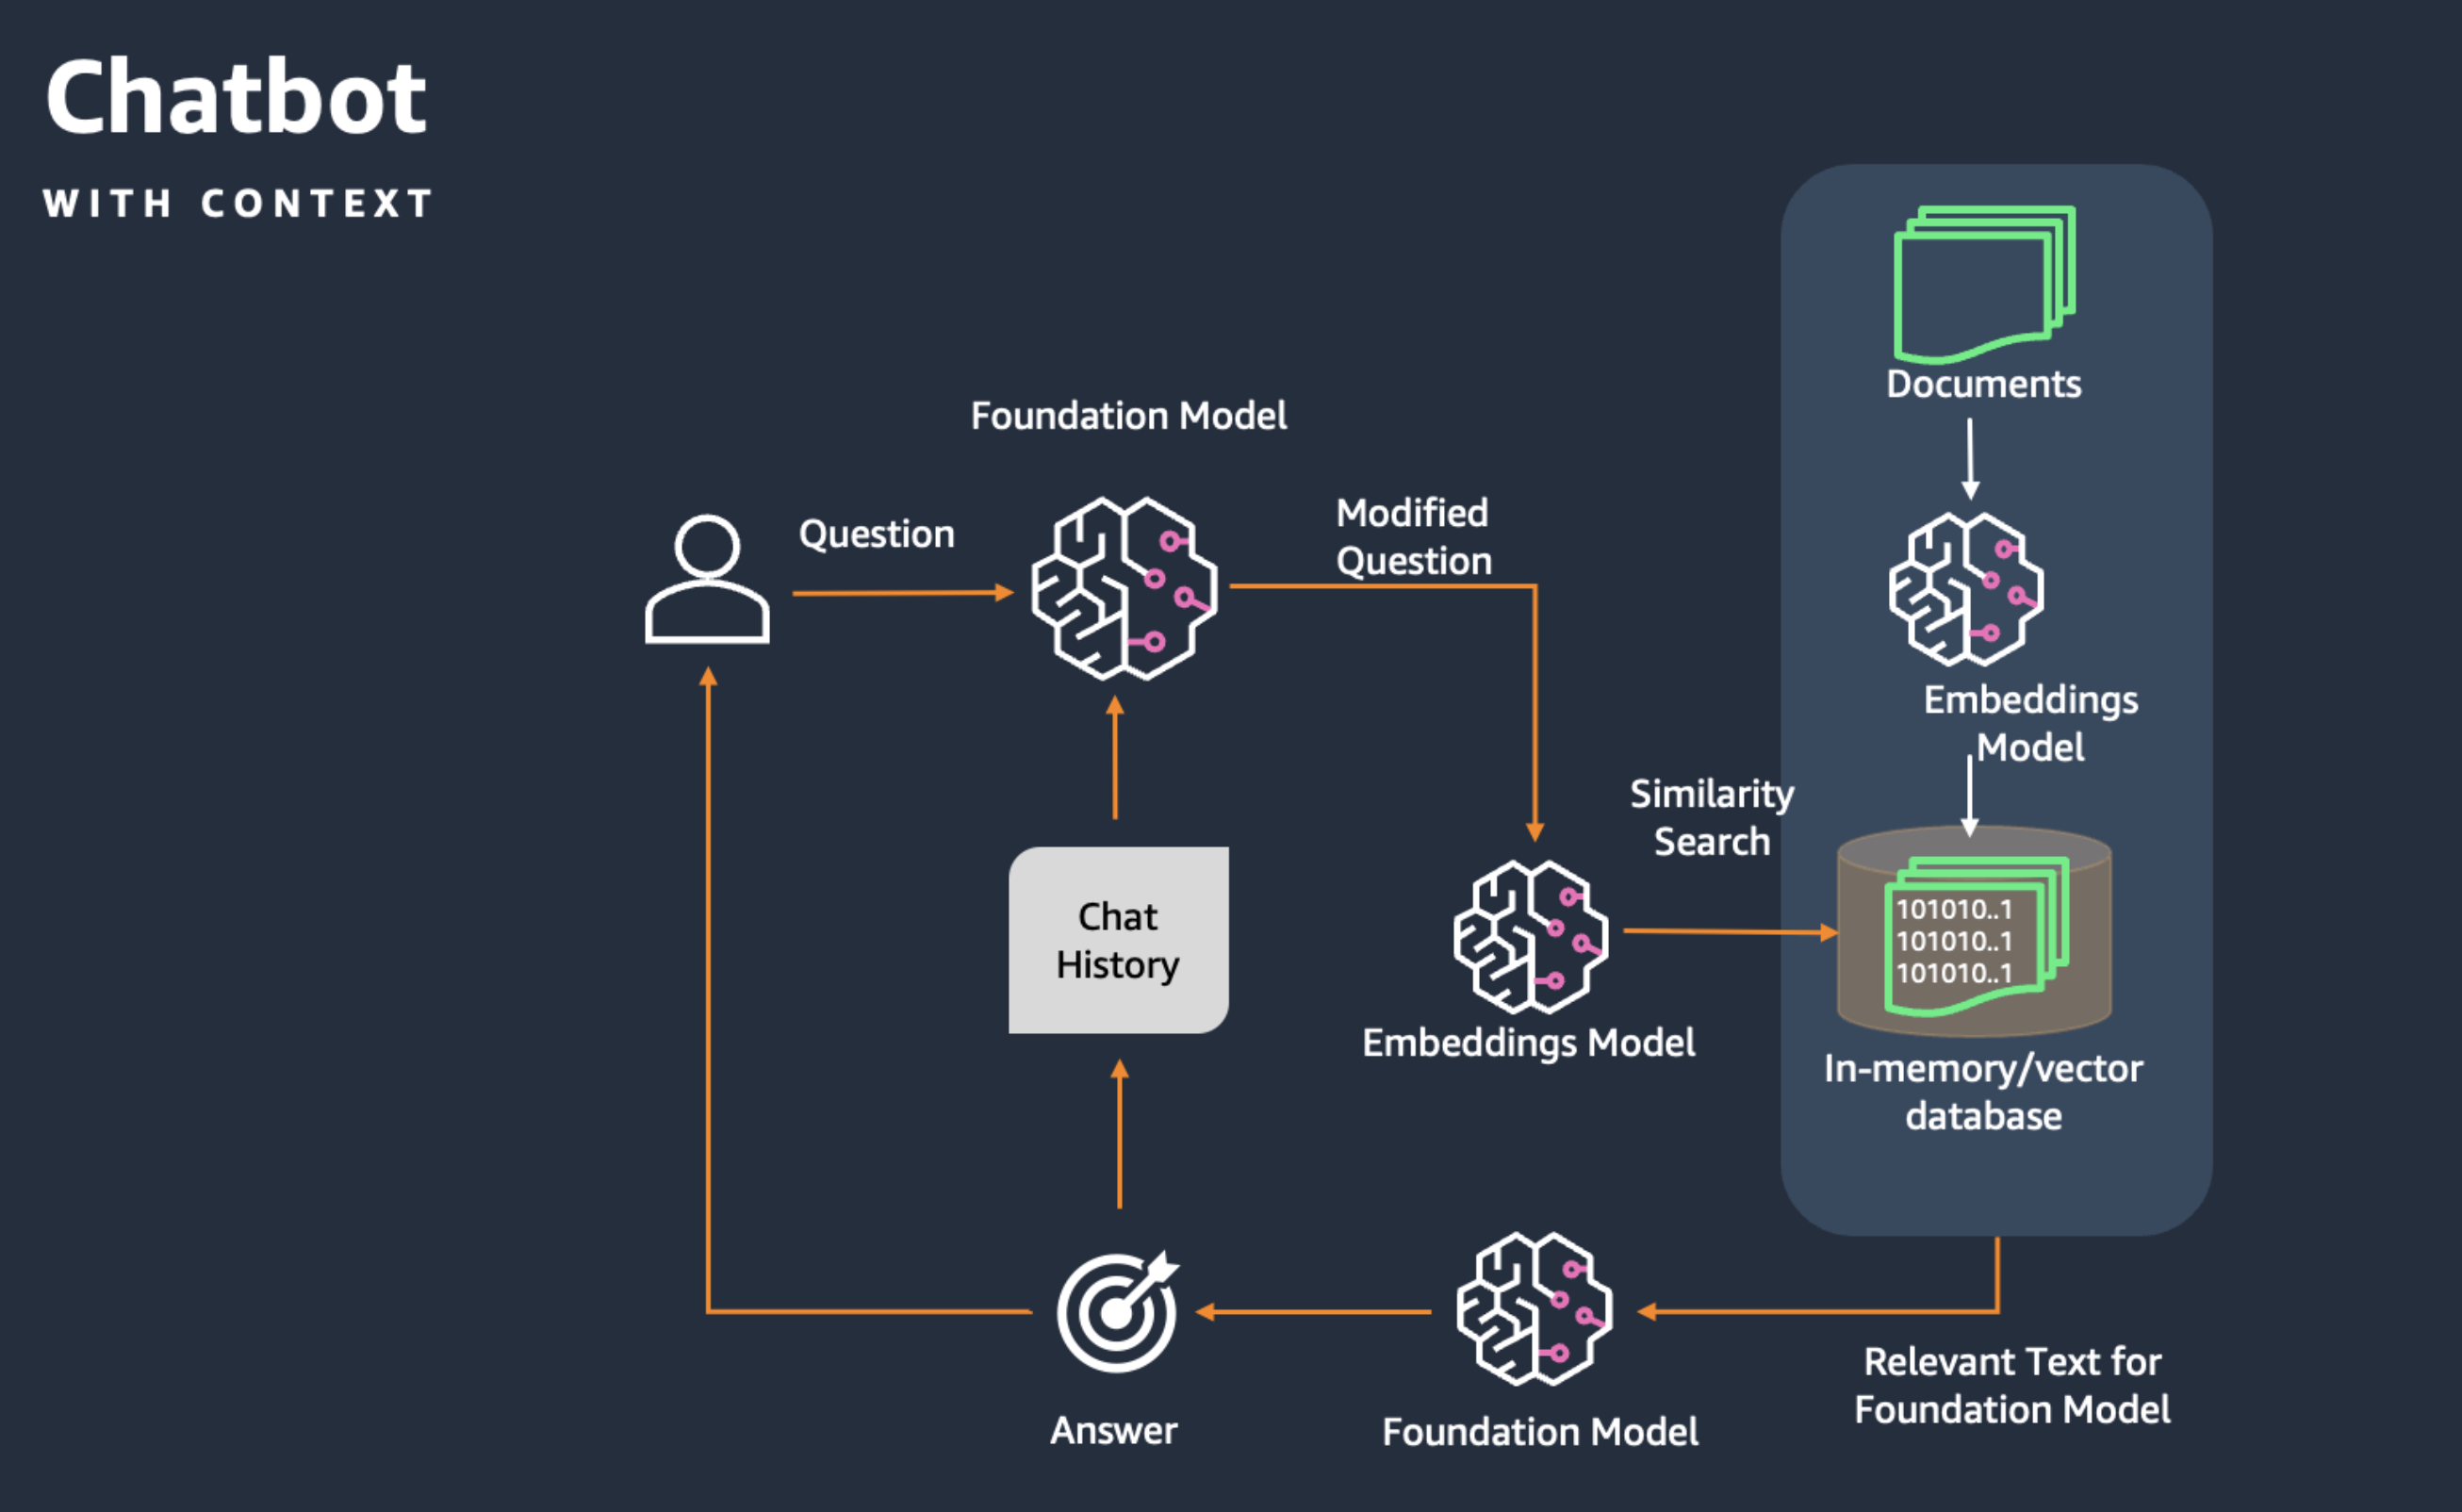

### Set the configuration parameters using environment variables
1. `SERVING_LOAD_MODELS` - specifies the engine that will be used for this workload. In this case we'll be hosting a model using the **Python** engine.

2. `OPTION_MODEL_ID`: Set this to the URI of the Amazon S3 bucket that contains the model. When this is set, the container leverages [s5cmd](https://github.com/peak/s5cmd) to download the model from s3. This enables faster deployments by utilizing optimized approach within the DJL inference container to transfer the model from S3 into the hosting instance.
If you want to download the model from huggingface.co, you can set `OPTION_MODEL_ID` to the model id of a pre-trained model hosted inside a model repository on huggingface.co (https://huggingface.co/models). The container uses this model id to download the corresponding model repository on huggingface.co.

3. `OPTION_TENSOR_PARALLEL_DEGREE`: Set to the number of GPU devices over which DeepSpeed needs to partition the model. This parameter also controls the number of workers per model which will be started up when DJL serving runs. In this example we use the `ml.g5.12xlarge` instance that has 4 GPUs; hence this is set to 4.

4. `OPTION_ROLLING_BATCH`: This parameter enables the use of a particular batching technique for continuous or iteration level batching to enable merging multiple concurrent requests that arrive at different times for inference.
In scenarios that involves open ended generation and chatbots, there is a need for having a high throughput. [vLLM](https://arxiv.org/pdf/2309.06180.pdf) is a fast LLM inference and serving framework that uses techniques like PagedAttention and continuous batching to improve the throughput. Hence, we set the `rolling_batch` parameter to `vllm`. When using `vllm`, you can also use some [additional parameters](https://github.com/deepjavalibrary/djl-serving/blob/master/serving/docs/lmi/configurations_large_model_inference_containers.md#vllm).

5. `OPTION_MAX_ROLLING_BATCH_SIZE`: The maximum number of concurrent requests to be used in a batch by the model server for inference. Clients can still send more requests to the endpoint, they will be queued.


For more information on the available options, please refer to the [DJL Serving - SageMaker Large Model Inference Configurations](https://github.com/deepjavalibrary/djl-serving/blob/master/serving/docs/lmi/configurations_large_model_inference_containers.md)

In [ ]:
version = "0.27.0"
deepspeed_image = sagemaker.image_uris.retrieve(
    "djl-deepspeed", region = region, version = version
)
print(f"DeepSpeed image for vLLM is ----> {deepspeed_image}")

### Step 2.1: Create model (using boto3 API)

In [ ]:
#
# vLLM with DeepSpeed 
#

instance_type = "ml.g5.2xlarge"
model_name = "Llama-2-7b-chat-hf-vLLM"

# vLLM config
vllm_config = {
    "SERVING_LOAD_MODELS": "test::Python=/opt/ml/model",
    "OPTION_MODEL_ID": "TheBloke/Llama-2-7B-Chat-fp16",
    "OPTION_ROLLING_BATCH": "vllm",
    "OPTION_TENSOR_PARALLEL_DEGREE": "max",
    "OPTION_MAX_ROLLING_BATCH_SIZE": "32",
    "OPTION_MAX_INPUT_LEN": "1024",
    "OPTION_MAX_OUTPUT_LEN": "2048",
    "OPTION_MAX_MODEL_LEN": "2048",
    "OPTION_DTYPE": "fp16",
}

image_uri = deepspeed_image
env = vllm_config

create_model_response = sm_client.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = {
        "Image": image_uri,
        "Environment": env,
    }
)
model_arn = create_model_response["ModelArn"]
print(f"Created Model: {model_arn}")

### Step 2.2: Create endpoint configuration (boto3 API)

In [ ]:
endpoint_config_name = f"{model_name}-EP-config"
health_check_timeout = 600

endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants = [
        {
            "VariantName": "variant1",
            "ModelName": model_name,
            "InstanceType": instance_type,
            "InitialInstanceCount": 1,
            "ContainerStartupHealthCheckTimeoutInSeconds": health_check_timeout,
            "RoutingConfig": {
                'RoutingStrategy': 'LEAST_OUTSTANDING_REQUESTS'
            },
        },
    ],
)
endpoint_config_response

### Step 2.3: Create endpoint (boto3 API)

In [ ]:
#
# Create endpoint
#
endpoint_name = f"{model_name}-EP"

create_endpoint_response = sm_client.create_endpoint(
    EndpointName = endpoint_name, EndpointConfigName = endpoint_config_name
)
print(f"Created Endpoint: {create_endpoint_response['EndpointArn']}")

**Please note: the next step can run up to 10 minutes**

In [ ]:
#
# Using helper function to wait for the endpoint to be ready
#
sess.wait_for_endpoint(endpoint_name)

## Step 3: Run Inference

In [ ]:
#
# define payload
#
prompt = """You are an helpful Assistant, called Jarvis. Knowing everyting about AWS.
User: Can you tell me something about Amazon SageMaker?
Jarvis:"""

params = { "max_new_tokens": 256, "temperature": 0.1}

# hyperparameters for llm (remove "\nUser:" from stop conditions)
payload = {
  "inputs": prompt,
  "parameters": params
}

response_model = smr_client.invoke_endpoint(
    EndpointName = endpoint_name,
    Body = json.dumps(payload),
    ContentType = "application/json",
)

assistant = json.loads(response_model["Body"].read().decode("utf8"))["generated_text"]
print(assistant)

### Step 3.1: Test inference performance

In [ ]:
# 
# Calculate runtime performance
# 
import time
import numpy as np

# define payload
prompt = """You are an helpful Assistant, called Jarvis. Knowing everyting about AWS.

User: Can you tell me something about Amazon SageMaker?
Jarvis:"""

params = { "max_new_tokens": 256, "temperature": 0.1}

# hyperparameters for llm (remove "\nUser:" from stop conditions)
payload = {
  "inputs": prompt,
  "parameters": params
}

results = []
for i in range(0, 10):
    start = time.time()
    response_model = smr_client.invoke_endpoint(
        EndpointName=endpoint_name,
        Body=json.dumps(payload),
        ContentType="application/json",
    )
    results.append((time.time() - start) * 1000)

print("\nPredictions for model latency: \n")
print("P95: " + str(np.percentile(results, 95)) + " ms")
print("P90: " + str(np.percentile(results, 90)) + " ms")
print("Average: " + str(np.average(results)) + " ms")

## Step 4: Cleanup

In [ ]:
sess.delete_endpoint(endpoint_name)
sess.delete_endpoint_config(endpoint_config_name)
sess.delete_model(model_name)

## Step 5: Endpoint Deployment (LMI - TensorRT-LLM)

### Use case: Summarization
This use-case is characterized by prompts that have a high number of tokens and generated output that has a lower number of tokens.

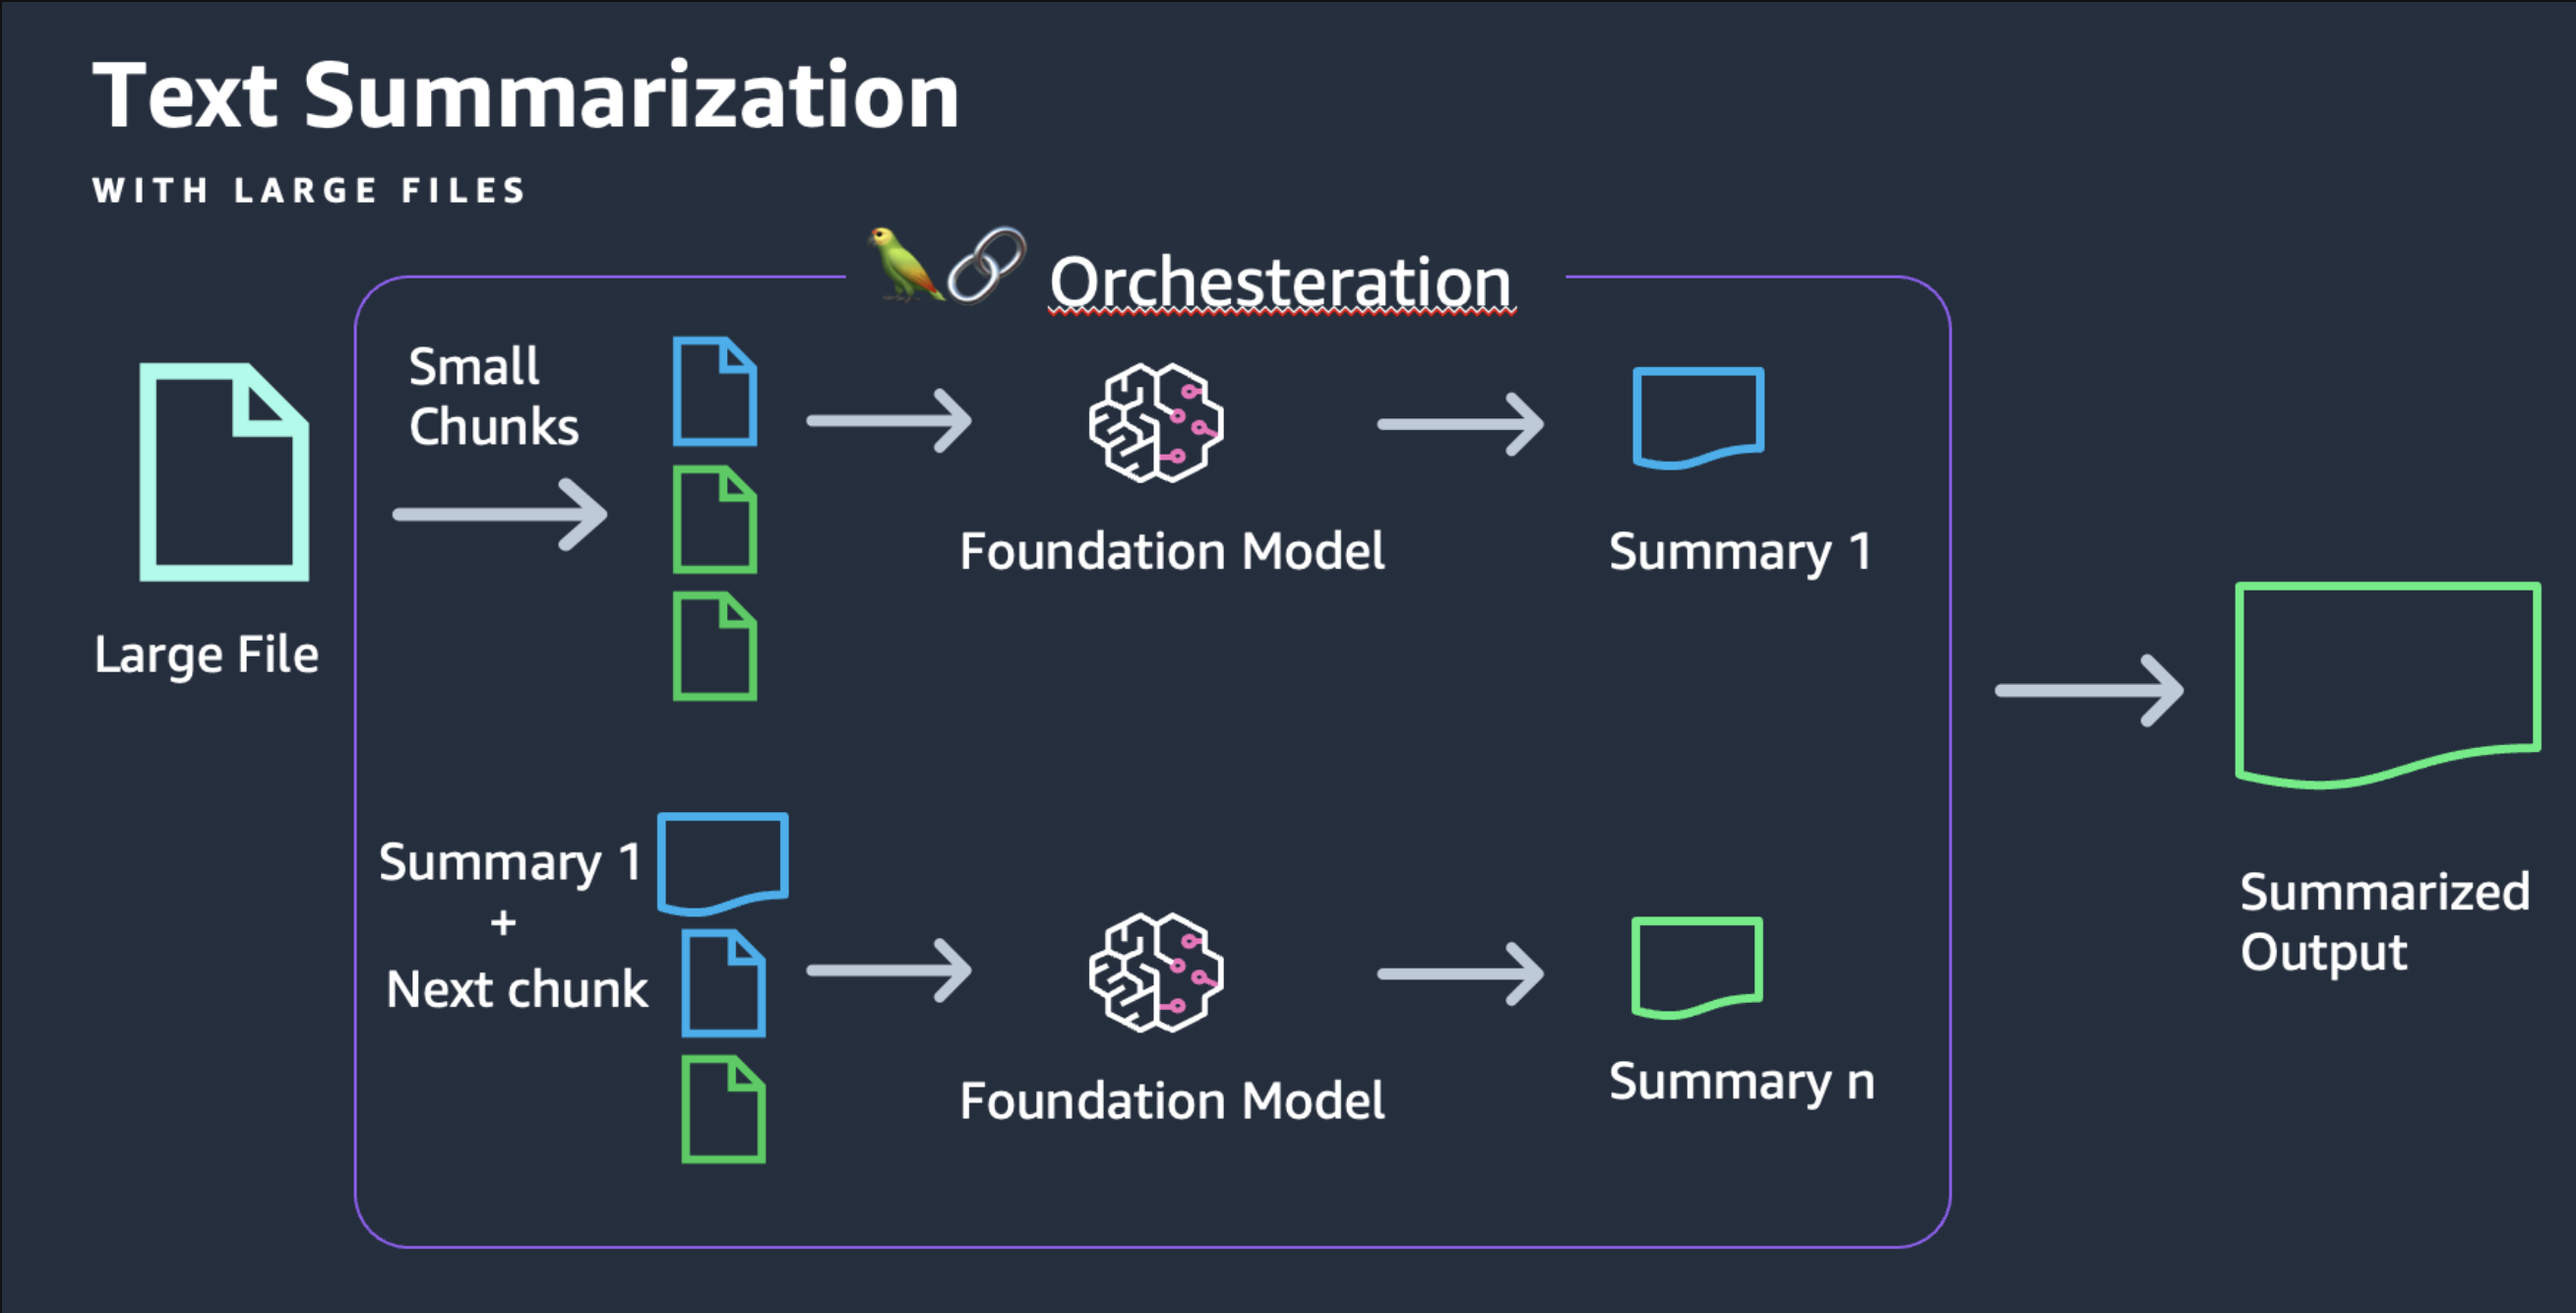

In [ ]:
version = "0.27.0"
trtllm_image = sagemaker.image_uris.retrieve(
    "djl-tensorrtllm", region=region, version=version
)
print(f"TensorRT-LLM image is ----> {trtllm_image}")

### Set the configuration parameters using environment variables
1. `SERVING_LOAD_MODELS` - specifies the engine that will be used for this workload. In this case we'll be hosting a model using the **MPI**. **MPI** is an engine that allows the model server to start distributed processes to load and serve the model.

2. `OPTION_ROLLING_BATCH`: This parameter enables the use of a particular batching technique for continuous or iteration level batching to enable merging multiple concurrent requests that arrive at different times for inference. [TensorRT-LLM](https://github.com/NVIDIA/TensorRT-LLM) is a TensorRT Toolbox for Optimized Large Language Model Inference on Nvidia GPUs. To leverage this, we set this parameter to `trtllm`. 
 

For more information on the available options, please refer to the [DJL Serving - SageMaker Large Model Inference Configurations](https://github.com/deepjavalibrary/djl-serving/blob/master/serving/docs/lmi/configurations_large_model_inference_containers.md)

### Step 5.1: Create model

In [ ]:
#
instance_type = "ml.g5.16xlarge" # required for TensorRT-LLM Just In Time Compilation
model_name = "Llama-2-7b-chat-hf-TRTLLM"

trtllm_config = {
    "SERVING_LOAD_MODELS": "test::MPI=/opt/ml/model",
    "OPTION_MODEL_ID": "TheBloke/Llama-2-7B-Chat-fp16",
    "OPTION_TENSOR_PARALLEL_DEGREE": "max",
    "OPTION_ROLLING_BATCH": "trtllm",
    "OPTION_MAX_INPUT_LEN": "1024",
    "OPTION_MAX_OUTPUT_LEN": "2048",
    "OPTION_MAX_ROLLING_BATCH_SIZE": "2"
}

image_uri = trtllm_image
env = trtllm_config

create_model_response = sm_client.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = {
        "Image": image_uri,
        "Environment": env,
    }
)
model_arn = create_model_response["ModelArn"]

print(f"Created Model: {model_arn}")

### Step 5.2: Create endpoint configuration

In [ ]:
endpoint_config_name = f"{model_name}-EP-config"
health_check_timeout = 1200

endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants = [
        {
            "VariantName": "variant1",
            "ModelName": model_name,
            "InstanceType": instance_type,
            "InitialInstanceCount": 1,
            "ContainerStartupHealthCheckTimeoutInSeconds": health_check_timeout,
            "RoutingConfig": {
                'RoutingStrategy': 'LEAST_OUTSTANDING_REQUESTS'
            },
        },
    ],
)
endpoint_config_response

### Step 5.3: Create endpoint

In [ ]:
#
# Create endpoint
#
endpoint_name = f"{model_name}-EP"

create_endpoint_response = sm_client.create_endpoint(
    EndpointName = endpoint_name, EndpointConfigName = endpoint_config_name
)
print(f"Created Endpoint: {create_endpoint_response['EndpointArn']}")

**Please note: the next step can run up to 15 minutes because we are using Just In Time compilation**

In [ ]:
#
# Using helper function to wait for the endpoint to be ready
#
sess.wait_for_endpoint(endpoint_name)

## Step 6: Run Inference (TensorRT-LLM)

In [ ]:
#
# define payload
#
prompt = """You are an helpful Assistant, called Jarvis. Knowing everyting about AWS.

User: Can you tell me something about Amazon SageMaker?
Jarvis:"""

params = { "max_new_tokens": 256, "temperature": 0.1}

# hyperparameters for llm (remove "\nUser:" from stop conditions)
payload = {
  "inputs": prompt,
  "parameters": params
}

response_model = smr_client.invoke_endpoint(
    EndpointName = endpoint_name,
    Body = json.dumps(payload),
    ContentType = "application/json",
)

assistant = json.loads(response_model["Body"].read().decode("utf8"))["generated_text"]
print(assistant)

### Step 6.1: Test inference performance (TensorRT-LLM)

In [ ]:
# 
# Calculate runtime performance
# 
import time
import numpy as np

# define payload
prompt = """You are an helpful Assistant, called Jarvis. Knowing everyting about AWS.

User: Can you tell me something about Amazon SageMaker?
Jarvis:"""

params = { "max_new_tokens": 256, "temperature": 0.1}

# hyperparameters for llm (remove "\nUser:" from stop conditions)
payload = {
  "inputs": prompt,
  "parameters": params
}

results = []
for i in range(0, 10):
    start = time.time()
    response_model = smr_client.invoke_endpoint(
        EndpointName=endpoint_name,
        Body=json.dumps(payload),
        ContentType="application/json",
    )
    results.append((time.time() - start) * 1000)

print("\nPredictions for model latency: \n")
print("P95: " + str(np.percentile(results, 95)) + " ms")
print("P90: " + str(np.percentile(results, 90)) + " ms")
print("Average: " + str(np.average(results)) + " ms")

## Step 7: Cleanup

In [ ]:
sess.delete_endpoint(endpoint_name)
sess.delete_endpoint_config(endpoint_config_name)
sess.delete_model(model_name)

## Step 8. Configure quantized Llama2-7b-chat-hf model using vLLM

In [ ]:
version = "0.27.0"
deepspeed_image = sagemaker.image_uris.retrieve(
    "djl-deepspeed", region=region, version=version
)
print(f"DeepSpeed image with vLLM is ----> {deepspeed_image}")

### Set the configuration parameters using environment variables
1. `SERVING_LOAD_MODELS` - specifies the engine that will be used for this workload. In this case we'll be hosting a model using the **Python** engine.

2. `OPTION_MODEL_ID`: Set this to the URI of the Amazon S3 bucket that contains the model. When this is set, the container leverages [s5cmd](https://github.com/peak/s5cmd) to download the model from s3. This enables faster deployments by utilizing optimized approach within the DJL inference container to transfer the model from S3 into the hosting instance.
If you want to download the model from huggingface.co, you can set `OPTION_MODEL_ID` to the model id of a pre-trained model hosted inside a model repository on huggingface.co (https://huggingface.co/models). The container uses this model id to download the corresponding model repository on huggingface.co.

3. `OPTION_TENSOR_PARALLEL_DEGREE`: Set to the number of GPU devices over which DeepSpeed needs to partition the model. This parameter also controls the number of workers per model which will be started up when DJL serving runs. In this example we use the `ml.g5.12xlarge` instance that has 4 GPUs; hence this is set to 4.

4. `OPTION_ROLLING_BATCH`: This parameter enables the use of a particular batching technique for continuous or iteration level batching to enable merging multiple concurrent requests that arrive at different times for inference.
In scenarios that involves open ended generation and chatbots, there is a need for having a high throughput. [vLLM](https://arxiv.org/pdf/2309.06180.pdf) is a fast LLM inference and serving framework that uses techniques like PagedAttention and continuous batching to improve the throughput. Hence, we set the `rolling_batch` parameter to `vllm`. When using `vllm`, you can also use some [additional parameters](https://github.com/deepjavalibrary/djl-serving/blob/master/serving/docs/lmi/configurations_large_model_inference_containers.md#vllm).

5. `OPTION_MAX_ROLLING_BATCH_SIZE`: The maximum number of concurrent requests to be used in a batch by the model server for inference. Clients can still send more requests to the endpoint, they will be queued.

6.`OPTION_QUANTIZE`: This parameter enables the use of a quantized (AWQ) models using vLLM backend. 

For more information on the available options, please refer to the [DJL Serving - SageMaker Large Model Inference Configurations](https://github.com/deepjavalibrary/djl-serving/blob/master/serving/docs/lmi/configurations_large_model_inference_containers.md)

### Step 8.1: Create model

In [ ]:
#
# vLLM with DeepSpeed 
#

instance_type = "ml.g5.2xlarge"
model_name = "Llama-2-7b-chat-hf-AWQ"

# vLLM config
vllm_config = {
    "SERVING_LOAD_MODELS": "test::Python=/opt/ml/model",
    "OPTION_MODEL_ID": "TheBloke/Llama-2-7B-Chat-AWQ",
    "OPTION_ROLLING_BATCH": "vllm",
    "OPTION_TENSOR_PARALLEL_DEGREE": "max",
    "OPTION_MAX_ROLLING_BATCH_SIZE": "2",
    "OPTION_MAX_INPUT_LEN": "1024",
    "OPTION_MAX_OUTPUT_LEN": "2048",
    "OPTION_MAX_MODEL_LEN": "2048",
    "OPTION_QUANTIZE": "awq",
    "OPTION_DTYPE": "auto",
}

image_uri = deepspeed_image
env = vllm_config

create_model_response = sm_client.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = {
        "Image": image_uri,
        "Environment": env,
    }
)
model_arn = create_model_response["ModelArn"]
print(f"Created Model: {model_arn}")

### Step 8.2: Create endpoint configuration

In [ ]:
endpoint_config_name = f"{model_name}-EP-config"
health_check_timeout = 1200

endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants = [
        {
            "VariantName": "variant1",
            "ModelName": model_name,
            "InstanceType": instance_type,
            "InitialInstanceCount": 1,
            "ContainerStartupHealthCheckTimeoutInSeconds": health_check_timeout,
            "RoutingConfig": {
                'RoutingStrategy': 'LEAST_OUTSTANDING_REQUESTS'
            },
        },
    ],
)
endpoint_config_response

### Step 8.3: Create endpoint

In [ ]:
#
# Create endpoint
#
endpoint_name = f"{model_name}-EP"

create_endpoint_response = sm_client.create_endpoint(
    EndpointName = endpoint_name, EndpointConfigName = endpoint_config_name
)
print(f"Created Endpoint: {create_endpoint_response['EndpointArn']}")

**Please note: the next step can run up to 10 minutes**

In [ ]:
#
# Using helper function to wait for the endpoint to be ready
#
sess.wait_for_endpoint(endpoint_name)

## Step 9: Inference (vLLM - AWQ)

In [ ]:
#
# define payload
#
prompt = """You are an helpful Assistant, called Jarvis. Knowing everyting about AWS.

User: Can you tell me something about Amazon SageMaker?
Jarvis:"""

params = { "max_new_tokens": 256, "temperature": 0.1}

# hyperparameters for llm (remove "\nUser:" from stop conditions)
payload = {
  "inputs": prompt,
  "parameters": params
}

response_model = smr_client.invoke_endpoint(
    EndpointName = endpoint_name,
    Body = json.dumps(payload),
    ContentType = "application/json",
)

assistant = json.loads(response_model["Body"].read().decode("utf8"))["generated_text"]
print(assistant)

### Step 9.1: Test inference performance

In [ ]:
# 
# Calculate runtime performance
# 
import time
import numpy as np

# define payload
prompt = """You are an helpful Assistant, called Jarvis. Knowing everyting about AWS.

User: Can you tell me something about Amazon SageMaker?
Jarvis:"""

params = { "max_new_tokens": 256, "temperature": 0.1}

# hyperparameters for llm (remove "\nUser:" from stop conditions)
payload = {
  "inputs": prompt,
  "parameters": params
}

results = []
for i in range(0, 10):
    start = time.time()
    response_model = smr_client.invoke_endpoint(
        EndpointName=endpoint_name,
        Body=json.dumps(payload),
        ContentType="application/json",
    )
    results.append((time.time() - start) * 1000)

print("\nPredictions for model latency: \n")
print("P95: " + str(np.percentile(results, 95)) + " ms")
print("P90: " + str(np.percentile(results, 90)) + " ms")
print("Average: " + str(np.average(results)) + " ms")

## Step 10. Cleanup

In [ ]:
sess.delete_endpoint(endpoint_name)
sess.delete_endpoint_config(endpoint_config_name)
sess.delete_model(model_name)